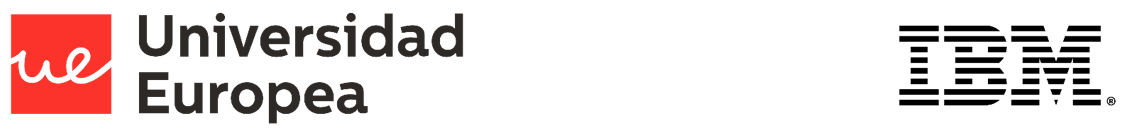

# MNIST
El set de datos de MNIST (Modified National Institute of Standards and Technology) es muy conocido en problemas de tratamiento y clasificación de imágenes con Machine Learning y Deep Learning y sirve como problema de prueba con el que se desarrollan y miden la mayoría de los algoritmos de clasificación de imágenes.

Consite en un set de imágenes con dígitos escritos a mano. Cada imagen, en blanco y negro y de 28x28 píxeles, contiene un dígito del 0 al 9, y está anotada (está identificado el dígito que contiene).

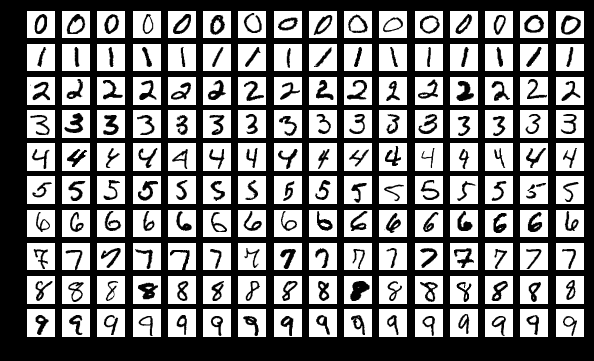

El problema consiste en identificar, dada una imagen, a cual de los dígitos corresponde (es un problema de clasificación). El set de datos contiene 70.000 imágenes de dígitos escritos a mano, separadas en 60.000 de training y 10.000 de testing.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import skimage
from skimage import io
from skimage import transform, filters
import torch
from skimage.feature import hog


from sklearn import linear_model, model_selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import random

In [ ]:
%matplotlib inline
np.random.seed(0)
mpl.rc("figure", figsize=(12, 12))

In [ ]:
#Instalacion de pytorch
#pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
def do_seeds(sn):
    np.random.seed(sn)
    torch.manual_seed(sn)
    random.seed(sn)
do_seeds(0)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')#%cd /gdrive

dpath = "/gdrive/My Drive/Colab Notebooks/Actividad1/"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
#%pip uninstall -y mxnet && pip install mxnet-cu90==1.1.0

In [ ]:


#torch.cuda.get_device_name(0)

# 1. Carga, visualización/exploración y reescalado de las imágenes (2 puntos)

Las imágenes están almacenadas en formato pickle. Antes de desarrollar el modelo, al igual que hemos hecho en ejercicios anteriores, hay que cargar los datos y conviene hacer una exploración y visualización de las imágenes.

Este apartado consiste en:
 - Cargar las imágenes desde el pickle y comprobar el número de filas y resolución del dataset
 - Visualizar una serie de imágenes
 - Reescalar las imágenes para que los valores de los datos estén entre -0.5 y 0.5

#### 1.1 - Cargar las imágenes desde el pickle y comprobar el número de filas y resolución del dataset

En el siguiente apartado se han cargado las imagenes guardadas en un pickle y posteriormente se ha comprobado el numero de filas.

In [ ]:
import pickle
# Documentacion de la libreria pickle y metodos asociados: https://python.readthedocs.io/en/stable/library/pickle.html


with open(f'{dpath}/data/MNIST_train.dat', 'rb') as file:
    (X_train, y_train) = pickle.load(file)
with open(f'{dpath}/data/MNIST_test.dat', 'rb') as file:
    (X_test, y_test) = pickle.load(file)

Es importante recalcar que el primer termino son el numero de imagenes, y los dos ultimos terminos se refiere a la resolucion de las imagenes.

In [ ]:
X_test.shape

(10000, 28, 28)

In [ ]:
X_train.shape

(60000, 28, 28)

#### 1.2 - Visualizar una serie de imágenes

Con la libreria scickit learn "skimage" se pueden convertir a imagenes cualquier tio de matriz ya que los pixeles funcionana de 0 a 255 en los tres canales de color segun RGB.

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


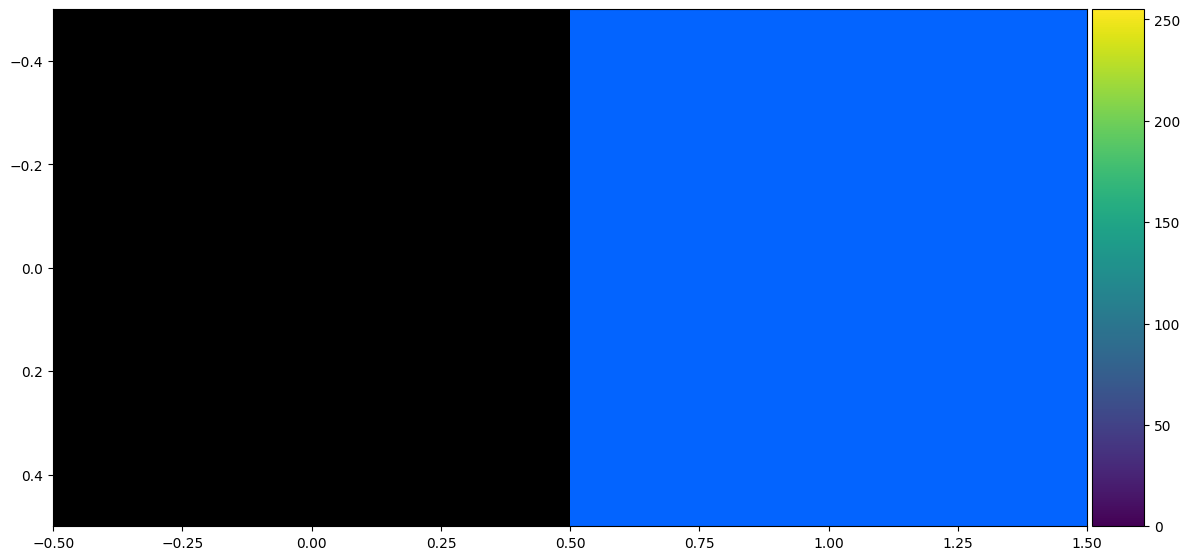

In [ ]:
#En el siguiente ejemplo podemos observar que la libreria skimage genera una image a partir de una matriz de numpy.
io.imshow(np.array([[[0, 0, 0], [3, 100, 255]]]))

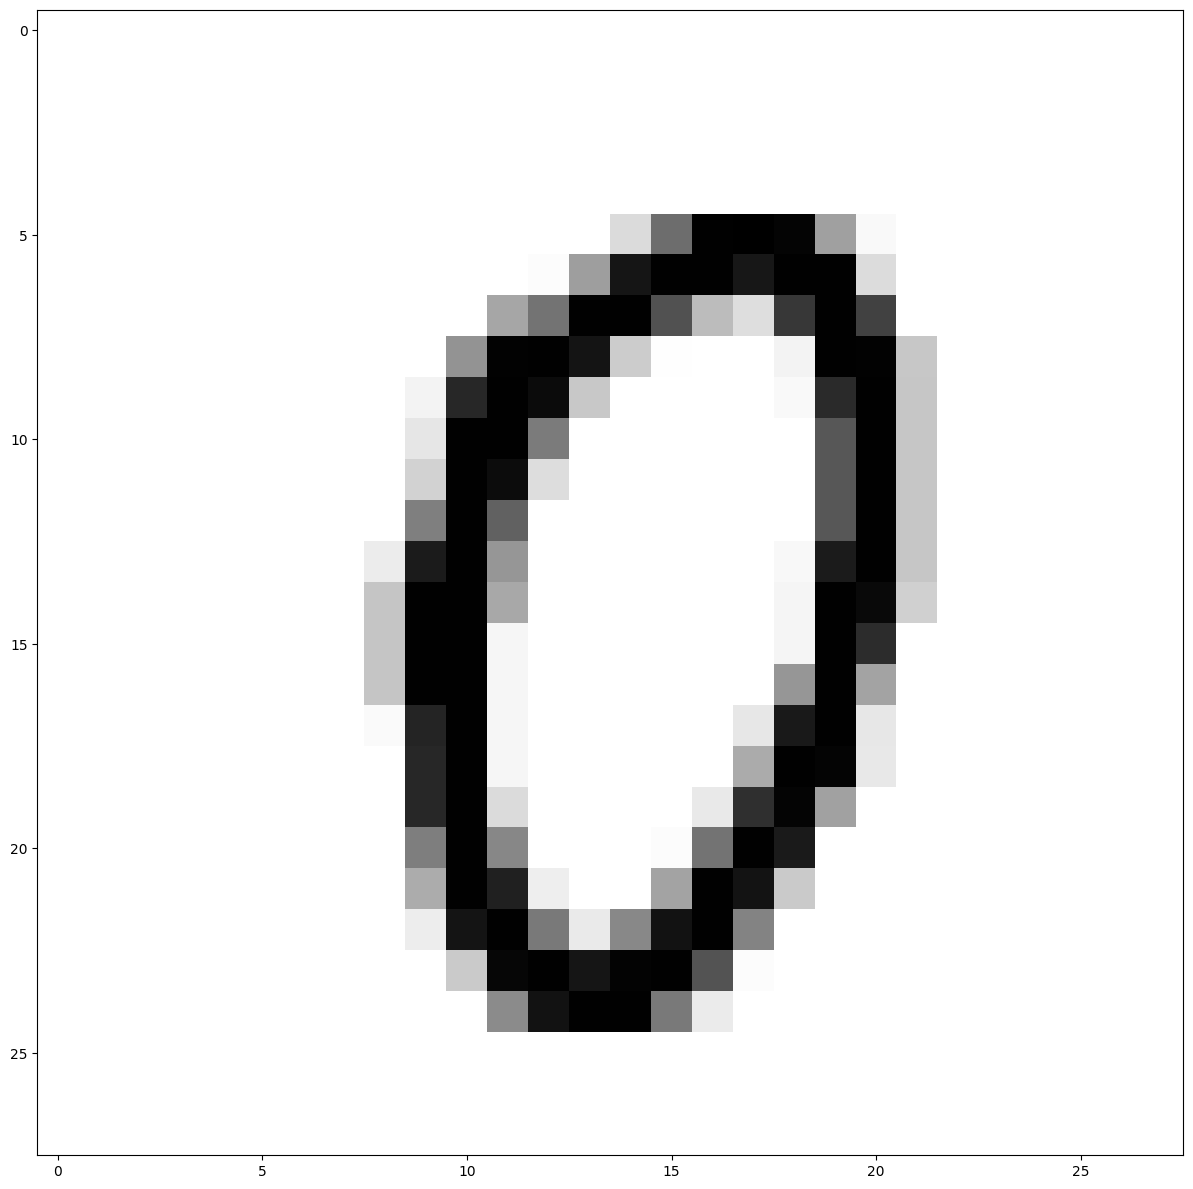

In [ ]:
io.imshow(255-X_train[1000,:,:])

#### 1.3 - Reescalar las imágenes para que los valores de los datos estén entre 0 y 1.

In [ ]:
X_train_n = (X_train.reshape(X_train.shape[0],-1) / 255.0)*1.0
X_test_n = (X_test.reshape(X_test.shape[0],-1) / 255.0)*1.0

In [ ]:
print(X_train_n[1])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

# 2. Entrenamiento de modelos de ML tradicionales con HOG features (2 puntos)

Para conseguir modelos mas robustos, podemos hacer uso de HOG features para procesar las imágenes de forma que obtengamos unas variables de entrada mas genéricas que los valores específicos de los píxeles.

Esta parte consiste en, al igual que hicimos en ejercicios anteriores:
 - Extraer las HOG features de las imágenes para obtener un dataset transformado con el que entrenar
 - Elegir 3 algoritmos de ML clásico (de scikit-learn) y entrenar modelos de clasificación con el dataset transformado

#### 2.1 - Extraer las HOG features de las imágenes para obtener un dataset transformado con el que entrenar

De acuerdo con lo que hemos visto en clase las HOG Features, consisten en un histograma del número de gradientes que apuntan en unas determinadas direcciones en varias zonas de la imagen. El número de direcciones a considerar y el tamaño de las ventanas son parámetros de la transformación.

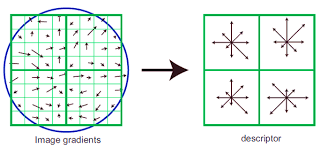


In [ ]:
# Explicacion detallada de HOG features -> https://www.youtube.com/watch?v=5nZGnYPyKL
# Documentacion -> https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html
# Parce ser que la normalizacion que ofrece mejores resultados es L1 debido a una serie de pruebas hechas con L1-hist, L2 y L2-hist acorde con la documentacion.


X_train_hog = np.concatenate([np.concatenate([hog(xi/255.0, orientations=8,
                                                   pixels_per_cell=(ppc, ppc),
                                                   cells_per_block=(1, 1),
                                                   visualize=False,
                                                   block_norm='L1')[np.newaxis, :] for xi in X_train[::10,:]],
                                              axis=0) for ppc in [14,7,4]], axis=1)
X_test_hog = np.concatenate([np.concatenate([hog(xi/255.0, orientations=8,
                                                   pixels_per_cell=(ppc, ppc),
                                                   cells_per_block=(1, 1),
                                                   visualize=False,
                                                   block_norm='L1')[np.newaxis, :] for xi in X_test[::10,:,]],
                                              axis=0) for ppc in [14,7,4]], axis=1)

In [ ]:
print(X_train_hog.shape)
print(X_test_hog.shape)

(6000, 552)
(1000, 552)


### 2.2 - Elegir 3 algoritmos de ML clásico (de scikit-learn) y entrenar modelos de clasificación con el dataset transformado

#### 2.2.1 - ML Clasico

In [ ]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


model_linear_clasico = svm.LinearSVC()
model_logistic_clasico = linear_model.LogisticRegression()
random_forest_clasico = RandomForestClassifier(n_estimators=100, random_state=123)

clasic_clasifiers = [model_linear_clasico, model_logistic_clasico, random_forest_clasico]
def hog_models(list_models, X, Y):
    for model in list_models:
        #1---En primer lugar realizaremos un fit de los modelos (X_train_hog, y=y_train[::10])
        model.fit(X,Y) # cogemos solo el 10% por tiempo de cálculo
        print(model.score(X,Y))


        #Realizamos un Cross Validation de nuestro modelo para que obtengamos las metricas pertinentes
        #
        name=f'{model}'
        kfold = model_selection.KFold(n_splits=10)
        cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

#Una vez realizada la funcion se puede observar el accuract de nuestros modelos con el croos-valiation realizado,
#en los siguientes apartados imprimiremos las metricas correspondientes
hog_models(clasic_clasifiers, X_train_n[::10], y_train[::10])




/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9791666666666666


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

LinearSVC(): 0.860500 (0.018059)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9726666666666667


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression(): 0.883333 (0.019551)
1.0
RandomForestClassifier(random_state=123): 0.926667 (0.009690)


#### 2.2.2 - HOG Features

#### En primer lugar, vamos a incluir el modelo de Regresion Lineal (HOG Feeatures):

In [ ]:
#Importamos la libreria de sklearn para la utilizacion del algoritmo predictivo.
from sklearn import svm
from sklearn import linear_model
from sklearn import model_selection

model_linear_hog = svm.LinearSVC()
model_logistic_hog = linear_model.LogisticRegression(solver='lbfgs', max_iter=80)
random_forest_hog = RandomForestClassifier(n_estimators=100, random_state=123)

hog_clasifiers = [model_linear_hog, model_logistic_hog, random_forest_hog]
def hog_models(list_models, X, Y):
    for model in list_models:
        #1---En primer lugar realizaremos un fit de los modelos (X_train_hog, y=y_train[::10])
        model.fit(X,Y) # cogemos solo el 10% por tiempo de cálculo


        #Realizamos un Cross Validation de nuestro modelo para  ue posteriormente obtengamos als metricas pertinentes
        name=f'{model}'
        kfold = model_selection.KFold(n_splits=10)
        cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

#Una vez realizada la funcion se puede observar el accuract de nuestros modelos con el croos-valiation realizado,
#en los siguientes apartados imprimiremos las metricas correspondientes
hog_models(hog_clasifiers, X_train_hog, y_train[::10])

LinearSVC(): 0.950667 (0.007717)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression(max_iter=80): 0.956000 (0.006758)
RandomForestClassifier(random_state=123): 0.954000 (0.007681)


# 3.	Grid search de hiperparámetros de los modelos y HOG features (1 punto)

Para refinar los modelos entrenados en el apartado anterior, en este apartado el objetivo es:
- Desarrollar una pipeline de scikit-learn con las transformaciones realizadas (incluyendo HOG features) y los modelos desarrollados
- Hacer un grid search sobre esta pipeline para hacer una selección de los hiperparámetros los modelos y de los hiperparámetros de la transformación HOG

Los hiperparametros son aquellos parametros de un algoritmo que no se van aprendiendo según se entrena el modelo, si no que son predefinidos antes de empezar el entrenamiento. Estos hiperparametros de definen cuando se crea el objeto estimador o predictor, en consequencia de esto el modelo que podamos obtener de primeras puede ser que no este ajustado debidamente y aqui entran los conceptos de Cross Validation y Grid Search.

El proceso de Cross Validation se realiza cuando necesitamos validar nuestro modelo predictivo ajustandolo el modelo con la muestra de entrenamiento y observando la prediccion con el conjunto de test, pero hay otro paso importante ya que hay introducir otra muestra para validar la combinacion de hiperparametros de nuestro modelo con la finalidad de encontrar los valores optimos.

Ecisten dos tecnicas d ebusqueda de hiperparametros que encuentran una combinacion de manera eficiente y especializada para cada modelo. Se trara de GridSearch y RandomSearch.

Ref: https://www.themachinelearners.com/busqueda-hiperparametros/


#### 3.1 - Desarrollar una pipeline de scikit-learn con las transformaciones realizadas (incluyendo HOG features) y los modelos desarrollados

En el apartado de aocntinuacion he realizado los pipelines de todos los modelos mencionados anteriormente con sus respectivos score de accuraccy. La precision del modelo deberia estar en torono al 100& con el dataset entero, pero como este notebook es de caracter academico y para facilitar la realizacion de los apartados se ha escogio un porcentaje de calculo del 10%.



Buen articulo en referencia al random state del modelo que es de utilidad sobre todo en el random search.
Ref:https://towardsdatascience.com/why-do-we-set-a-random-state-in-machine-learning-models-bb2dc68d8431

#### 3.1.1 - Pipelines de los modelos (ML clasico).

In [ ]:
# Scale the data
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_SVC = Pipeline([('scl', StandardScaler()),
                            ('model', model_linear_clasico)])


pipe_logistic = Pipeline([('scl', StandardScaler()),
                            ('model', model_logistic_clasico)])



pipe_rf = Pipeline([('scl', StandardScaler()),
                            ('model', random_forest_clasico)])



#### 3.1.2 - HOG Pipeline con Random Forest

In [ ]:
from sklearn.pipeline import Pipeline


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_SVC_HOG = Pipeline([('scl', StandardScaler()),
                            ('model', model_linear_hog)])


pipe_logistic_HOG = Pipeline([('scl', StandardScaler()),
                            ('model', model_logistic_hog)])



pipe_rf_HOG = Pipeline([('scl', StandardScaler()),
                            ('random', random_forest_hog)])

###  3.2 - Hacer un grid search sobre esta pipeline para hacer una selección de los hiperparámetros los modelos y de los hiperparámetros de la transformación HOG

#### 3.2.1 - Hiperparametros de nuestros modelos.

Como podemos observar a continuacion la cantidad de hiperparametros que contiene cada modelo es bastante grande por lo que optimizar esos hiperparametros al maximo nos facilitaria una mayor precision en nuestro modelo.Hay que tener en cuenta que 'tunear' estos parametros a mano pueded ser una tarea bastante tediosa por lo que hay que entra en juego los conceptos de Gridsearch y RandomSearch.



Ref: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
from pprint import pprint

for model in clasic_clasifiers:
    print(f'\n Parametros actualmente en {model}:\n')
    print(f'{pprint(model.get_params())}\n')


 Parametros actualmente en LinearSVC():

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}
None


 Parametros actualmente en LogisticRegression():

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}
None


 Parametros actualmente en RandomForestClassifier(random_state=123):

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_e

In [ ]:
for model in hog_clasifiers:
    print(f'\n Parametros actualmente en {model}:\n')
    print(f'{pprint(model.get_params())}\n')


 Parametros actualmente en LinearSVC():

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}
None


 Parametros actualmente en LogisticRegression(max_iter=80):

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 80,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}
None


 Parametros actualmente en RandomForestClassifier(random_state=123):

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 

#### 3.2.2 - Grid SearchCV

Como hemos explicado antoriormente vamos a hacer la tecnica de GridSearch junto a un Cross Validation para optimizar esos hiperparametros a nuestro problema de clasificacion.

Se ha aplicado una potencia de calculo inferior por lo que la precison del modelo sera mas baja de lo normal y se ha hecho el Grid Search en todos los modelos con la inclusion de una grafica mostrando el accuracy en cada iteracion. Esto ayuda a entender como funciona realmente GridSearch.


Mejores parámetros para LinearSVC: {'C': 0.1, 'loss': 'hinge'}
Puntuación del modelo LinearSVC: 0.8333333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Mejores parámetros para LogisticRegression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Puntuación del modelo LogisticRegression: 0.8366666666666667
Mejores parámetros para RandomForest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Puntuación del modelo RandomForest: 0.865


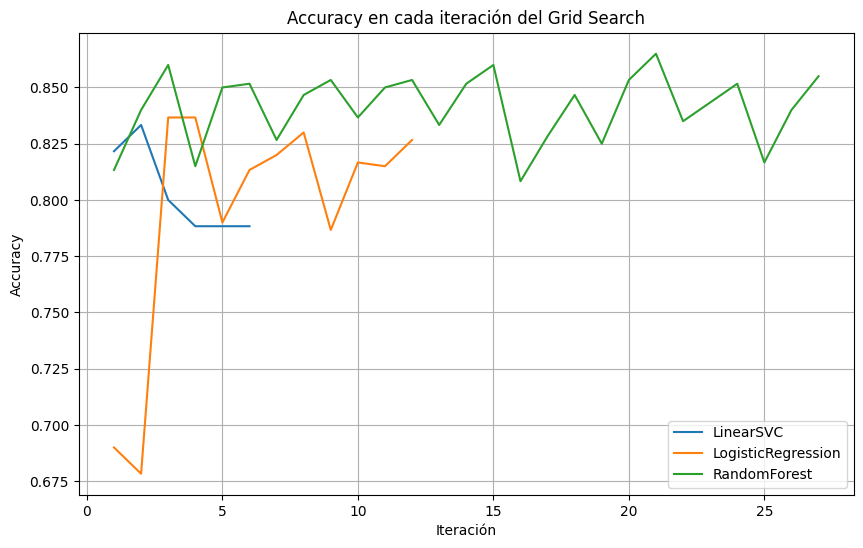

In [ ]:
# Modelos Clasicos

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score

# Define los modelos que deseas ajustar con Grid Search
models = {
    'LinearSVC': svm.LinearSVC(),
    'LogisticRegression': linear_model.LogisticRegression(),
    'RandomForest': RandomForestClassifier()
}

# Define los parámetros y rangos que deseas probar para cada modelo
param_grid = {
    'LinearSVC': {
        'C': [0.1, 1.0, 10.0],

        'loss': ['squared_hinge', 'hinge']
    },
    'LogisticRegression': {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
}
# Almacenar los resultados de accuracy en cada iteración
accuracy_results = {}

# Realiza la búsqueda de cuadrícula para cada modelo
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[model_name],error_score='raise', cv=5)
    grid_search.fit(X_train_n[::100], y_train[::100])  # Potencia de calculo inferior para no saturar el sistema

    accuracy_results[model_name] = grid_search.cv_results_['mean_test_score']

    # Imprime los mejores parámetros y puntuaciones del modelo
    print(f"Mejores parámetros para {model_name}: {grid_search.best_params_}")
    print(f"Puntuación del modelo {model_name}: {grid_search.best_score_}")


# Genera el gráfico de accuracy en cada iteración
plt.figure(figsize=(10, 6))
for model_name, accuracy_scores in accuracy_results.items():
    plt.plot(np.arange(1, len(accuracy_scores) + 1), accuracy_scores, label=model_name)

plt.xlabel('Iteración')
plt.ylabel('Accuracy')
plt.title('Accuracy en cada iteración del Grid Search')
plt.legend()
plt.grid(True)
plt.show()

Mejores parámetros para LinearSVC: {'C': 0.1, 'loss': 'squared_hinge'}
Puntuación del modelo LinearSVC: 0.9216666666666666


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Mejores parámetros para LogisticRegression: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Puntuación del modelo LogisticRegression: 0.9233333333333332
Mejores parámetros para RandomForest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Puntuación del modelo RandomForest: 0.925


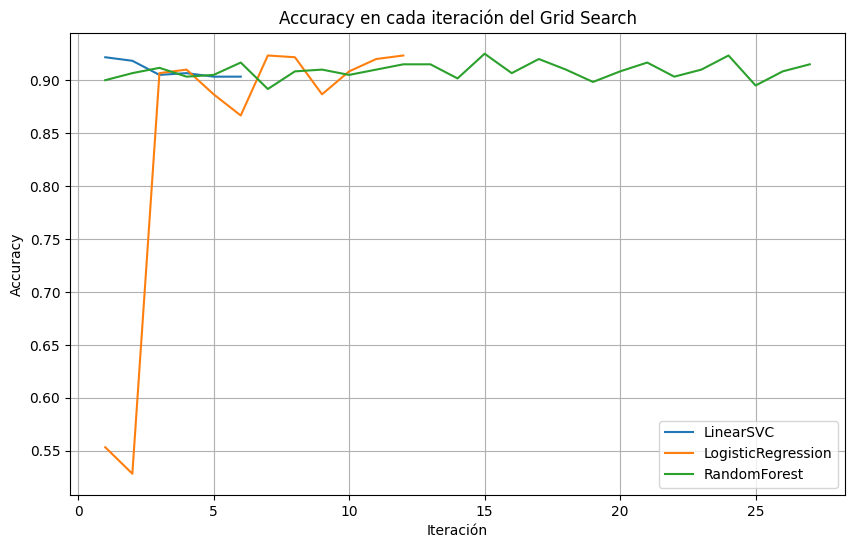

In [ ]:
# Hog Features

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score

# Define los modelos que deseas ajustar con Grid Search
models = {
    'LinearSVC': svm.LinearSVC(),
    'LogisticRegression': linear_model.LogisticRegression(),
    'RandomForest': RandomForestClassifier()
}

# Define los parámetros y rangos que deseas probar para cada modelo
param_grid = {
    'LinearSVC': {
        'C': [0.1, 1.0, 10.0],

        'loss': ['squared_hinge', 'hinge']
    },
    'LogisticRegression': {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
}
# Almacenar los resultados de accuracy en cada iteración
accuracy_results = {}

# Realiza la búsqueda de cuadrícula para cada modelo
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[model_name],error_score='raise', cv=5)
    grid_search.fit(X_train_hog[::10], y_train[::100])  # Potencia de calculo inferior para no saturar el sistema

    accuracy_results[model_name] = grid_search.cv_results_['mean_test_score']

    # Imprime los mejores parámetros y puntuaciones del modelo
    print(f"Mejores parámetros para {model_name}: {grid_search.best_params_}")
    print(f"Puntuación del modelo {model_name}: {grid_search.best_score_}")


# Genera el gráfico de accuracy en cada iteración
plt.figure(figsize=(10, 6))
for model_name, accuracy_scores in accuracy_results.items():
    plt.plot(np.arange(1, len(accuracy_scores) + 1), accuracy_scores, label=model_name)

plt.xlabel('Iteración')
plt.ylabel('Accuracy')
plt.title('Accuracy en cada iteración del Grid Search')
plt.legend()
plt.grid(True)
plt.show()

Caabe destacar que la potencia de calculo ha sido menor por lo que la precision del modelo puede haberse reducido.

# 4. Diseño de red neuronal “fully connected”, no convolucional. (1 punto)

Como hemos visto en la sesión de Deep Learning, los modelos de Deep Learning son capaces de "capturar" features a partir de los datos.

El objetivo de esta sección es:
- Construir una red neuronal no convolucional que tenga como input una imágen y como output la probabilidad asociada a cada clase (dígitos 0-9)
- Comprobar que la red definida funciona haciendo un forward pass (sin entrenarla)

### 4.1 - Construir una red neuronal no convolucional que tenga como input una imágen y como output la probabilidad asociada a cada clase (dígitos 0-9)

Primero implementaremos las variables en los tensores con pytorch normalizados ya que las imagenes van de 0 a 255.

In [ ]:
tX_train = torch.tensor(X_train / 255.0, requires_grad=False, dtype=torch.float)
tX_test = torch.tensor(X_test / 255.0 , requires_grad=False, dtype=torch.float)
ty_train = torch.tensor(y_train, requires_grad=False, dtype=torch.long)
ty_test = torch.tensor(y_test, requires_grad=False, dtype=torch.long)

In [ ]:
tX_train.shape

torch.Size([60000, 28, 28])

Una vez realizada la comprobacion de canales vamos a aplanar la imagen con la finalidad de implmentrla en nuestra red neuronal.

In [ ]:
tX_train_l = tX_train.view(tX_train.shape[0], 784)
tX_test_l = tX_test.view(tX_test.shape[0], 784)

In [ ]:
print(tX_train.shape)
print(tX_train_l.shape)

torch.Size([60000, 28, 28])
torch.Size([60000, 784])


### Implementacion del forward pass.

En Pytorch la orma tipica de construir una red es a partir de modulos. Un modulo es un objeto que implementa una funcion forward que lo que hace es implementar unos inputs y outputs Para hacer una capa lineal se usa el metodo torch.nn.Linear(unidades de entrada, unidades de salida). El vector bias es un valor adicional que tienen las capas lineales para ajustar los datos.

Lo que va hacer que la capa lineal para cada fila va acoger las n columnas del tensor y las va transformar en n columnas.

In [ ]:
linear_1 = torch.nn.Linear(784,10) # una capa lineal de 2 unidad de entrada y 10 unidades de salida.
linear_1

Linear(in_features=784, out_features=10, bias=True)

La mayor utildad de los módulos es que permiten un acceso organizado a los parámetros que contienen. Para acceder a los parámetros de un módulo simplemente utilizamos la función .parameters() o .named_parameters():

Nota: un parámetro es un objeto de tipo tensor con la propiedad especial de que los módulos lo identifican como parámetro 'entrenable' (con requires_grad=True).

In [ ]:
for name, param in linear_1.named_parameters():
    print(name, param)

weight Parameter containing:
tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
        [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
        [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
        ...,
        [ 0.0237,  0.0103, -0.0219,  ...,  0.0088, -0.0009,  0.0009],
        [ 0.0144, -0.0336, -0.0346,  ..., -0.0222, -0.0025, -0.0138],
        [-0.0196, -0.0118,  0.0230,  ..., -0.0202,  0.0172,  0.0355]],
       requires_grad=True)
bias Parameter containing:
tensor([-0.0092,  0.0277, -0.0110, -0.0335, -0.0282, -0.0120,  0.0338,  0.0150,
         0.0308,  0.0181], requires_grad=True)


Podemos encadenar módulos utilizando nn.Sequential (que, a su vez, es un módulo). Los módulos proporcionados al definir un nn.Sequential se aplican en el orden indicado, de forma que la función forward completa es el resultado de hacer el forward del primer módulo con los datos como input, hacer el forward del segundo módulo usando el output del primero como input, etc...

Siguiendo nuestra arquitectura, podemos definir nuestra red de la siguiente manera:

In [ ]:
#He mejorado la red neuronal implementando una clase para que este todo mas organizado.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class FullyConected(nn.Module):
    def __init__(self):
        super(FullyConected, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

    def evaluate(model, dataloader):
        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for batch_x, batch_y in dataloader:
                output = model(batch_x)
                _, pred = torch.max(output, 1)
                y_true.extend(batch_y.numpy())
                y_pred.extend(pred.numpy())
        model.train()
        return y_true, y_pred

def train_step(x, y, model, optimizer):
    optimizer.zero_grad()
    output = model(x)
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(x, y, model):
    with torch.no_grad():
        output = model(x)
        _, y_pred = torch.max(output, dim=1)
        score = torch.sum(y_pred == y).item() / len(y)
    return score


# Crear una instancia de la red neuronal
nn1 = FullyConected()




#nn1 = torch.nn.Sequential(
#    torch.nn.Linear(28*28, 100), # capa lineal con 28*28 entradas y 100 salidas, que es la capa de en medio.
#    torch.nn.ReLU(),  # activación ReLU
#    torch.nn.Linear(100, 10), # capa lineal con 100 entradas que es la "hidden layer" y 10 salidas que se refiere a los numeros que van del 0 al 9.
#    torch.nn.LogSoftmax(dim=1) # El output es la probabilidad de pertenencia a cada categoría
#)

#Nota: en lugar de Softmax hemos aplicado la función LogSoftmax que numéricamente es mucho mas estable
#(es el resultado de aplicarle el logaritmo a la función Softmax).
#Para recuperar las probabilidades podemos simplemente hacer exp(nn1(x)).

### 4.2 - Comprobar que la red definida funciona haciendo un forward pass (sin entrenarla)

Para comprobar que efectivamente nos devuelve dos columnas con probabilidades, introducimos un bloque de filas de nuestros datos (un 'batch') en el 'forward pass':

In [ ]:

output = nn1(tX_train_l[0:10,:])  # Ejecutar el forward pass
print(output)

tensor([[-2.4031, -2.2477, -2.2171, -2.1420, -2.4410, -2.2754, -2.4007, -2.2144,
         -2.3087, -2.4251],
        [-2.4724, -2.2356, -2.2509, -2.1742, -2.4498, -2.2915, -2.3207, -2.2170,
         -2.2499, -2.4113],
        [-2.3393, -2.2685, -2.2247, -2.2398, -2.3644, -2.3558, -2.3923, -2.1814,
         -2.3090, -2.3743],
        [-2.3189, -2.2992, -2.3174, -2.1966, -2.3589, -2.2798, -2.3038, -2.3300,
         -2.3005, -2.3293],
        [-2.3597, -2.3702, -2.2774, -2.1748, -2.3747, -2.2419, -2.3475, -2.2616,
         -2.2877, -2.3505],
        [-2.3950, -2.2964, -2.2511, -2.1413, -2.3436, -2.2591, -2.3002, -2.3062,
         -2.3098, -2.4554],
        [-2.2945, -2.2185, -2.3254, -2.1830, -2.3922, -2.2595, -2.4077, -2.2875,
         -2.3097, -2.3718],
        [-2.4855, -2.2506, -2.2902, -2.1148, -2.3982, -2.3514, -2.3415, -2.1673,
         -2.2821, -2.4011],
        [-2.3286, -2.2307, -2.3240, -2.2318, -2.4052, -2.2737, -2.3324, -2.2807,
         -2.2853, -2.3466],
        [-2.4264, -

In [ ]:
nn1(tX_train_l).shape

torch.Size([60000, 10])

Para ejecutar los cáclulos en la GPU movemos los tensores y _modules_ a la GPU:

In [ ]:
#nn1 = nn1.cuda()
#tX_train_l = tX_train_l.cuda()
#tX_test_l = tX_test_l.cuda()
#tX_train = tX_train.cuda()
#tX_test = tX_test.cuda()
#ty_train = ty_train.cuda()
#ty_test = ty_test.cuda()

# 5. Entrenamiento red neuronal “fully connected”. (0,5 puntos)

El objetivo de esta sección es entrenar la red definida en el apartado anterior y comprobar su rendimiento en el set de testing. Se ha mejorado el codigo con respecto al notebook y se han incluido algunas features gracias  a la documentacion de Pytorch.

Podemos observar que por cada epoch hay una mejora significativa en la precision de la red neuronal.

Epoch: 0, Loss: 2.3085, Accuracy: 0.1116
Epoch: 100, Loss: 2.2685, Accuracy: 0.2380
Epoch: 200, Loss: 2.2274, Accuracy: 0.3640
Epoch: 300, Loss: 2.1826, Accuracy: 0.4600
Epoch: 400, Loss: 2.1330, Accuracy: 0.5222
Epoch: 500, Loss: 2.0777, Accuracy: 0.5716
Epoch: 600, Loss: 2.0161, Accuracy: 0.6173
Epoch: 700, Loss: 1.9482, Accuracy: 0.6545
Epoch: 800, Loss: 1.8749, Accuracy: 0.6800
Epoch: 900, Loss: 1.7970, Accuracy: 0.6999


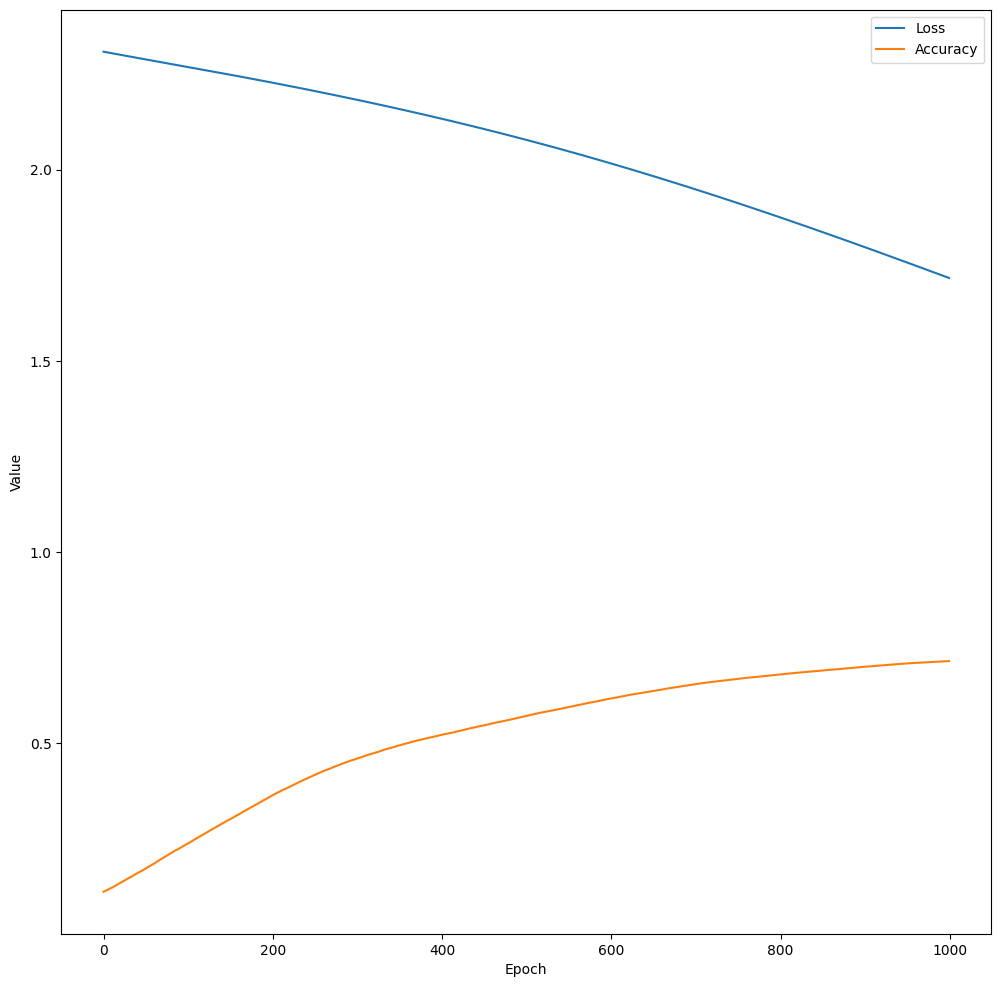

In [ ]:
# Crear el optimizador
optimizer = optim.SGD(nn1.parameters(), lr=0.0025)

# Listas para almacenar el accuracy y el loss
accuracy_list = []
loss_list = []

# Entrenamiento
for epoch in range(1000):
    loss = train_step(tX_train_l, ty_train, nn1, optimizer)
    accuracy = evaluate(tX_train_l, ty_train, nn1)

    loss_list.append(loss)
    accuracy_list.append(accuracy)

    if epoch % 100 == 0:
        print("Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f}".format(epoch, loss, accuracy))

# Visualización del accuracy y el loss
plt.plot(loss_list, label='Loss')
plt.plot(accuracy_list, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

**Mejora del entrenamiento.**

El entrenamiento con mini-batches consiste en utilizar un número reducido de filas sampleadas del set de training en cada paso de entrenamiento, en lugar de utilizar el set de training completo. Cuando se consumen todas las filas del set de datos al cabo de un cierto número de iteraciones, se vuelve a empezar (cada paso completo por el set de datos se denomina epoch). Esto permite dar mas pasos de optimización por cada epoch y por un lado acelera el entrenamiento y por otro ayuda a evitar mínimos locales, reduciendo el overfitting.

Podemos implementar los mini-batches en Pytorch de la siguiente manera:

Epoch: 0, Loss: 1.1410, Accuracy: 0.7739
Epoch: 100, Loss: 0.1531, Accuracy: 0.9434
Epoch: 200, Loss: 0.1565, Accuracy: 0.9623
Epoch: 300, Loss: 0.1040, Accuracy: 0.9726
Epoch: 400, Loss: 0.0524, Accuracy: 0.9791
Epoch: 500, Loss: 0.0423, Accuracy: 0.9828
Epoch: 600, Loss: 0.0748, Accuracy: 0.9852
Epoch: 700, Loss: 0.0270, Accuracy: 0.9880
Epoch: 800, Loss: 0.0414, Accuracy: 0.9898
Epoch: 900, Loss: 0.0495, Accuracy: 0.9912


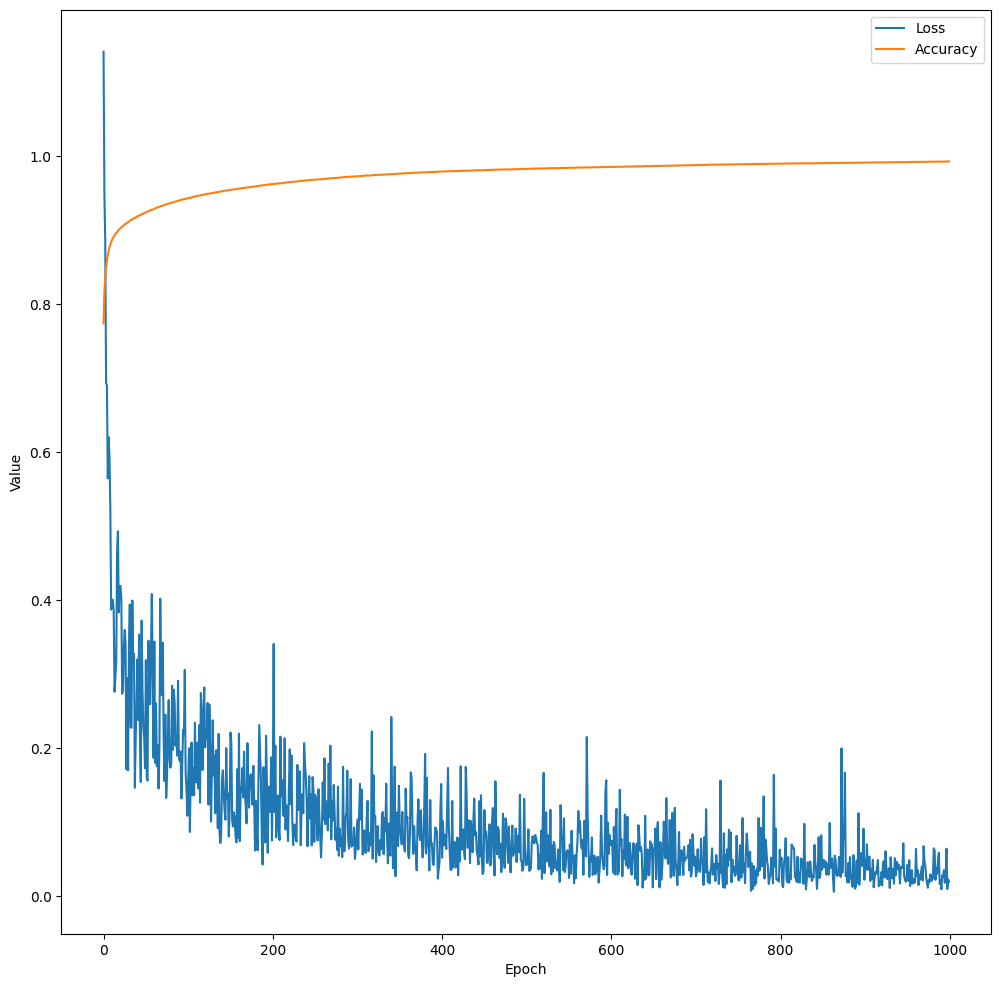

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
# Crear el dataset y el DataLoader
dataset = TensorDataset(tX_train_l, ty_train)
dataloader_nn1 = DataLoader(dataset, batch_size=100, shuffle=True)

# Crear el optimizador
optimizer = optim.SGD(nn1.parameters(), lr=0.0025)

# Listas para almacenar el accuracy y el loss
accuracy_list = []
loss_list = []

# Entrenamiento
for epoch in range(1000):
    for batch_x, batch_y in dataloader_nn1:
        loss = train_step(batch_x, batch_y, nn1, optimizer)

    accuracy = evaluate(tX_train_l, ty_train, nn1)
    loss_list.append(loss)
    accuracy_list.append(accuracy)

    if epoch % 100 == 0:
        print("Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f}".format(epoch, loss, accuracy))

# Visualización del accuracy y el loss
plt.plot(loss_list, label='Loss')
plt.plot(accuracy_list, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

Como podemos observar el uso de minibatches mejora significativamente la precision del modelo evitando el overfitting.

# 6. Diseño de red neuronal convolucional. (1 punto)

Como hemos visto en la sesión de Deep Learning, las redes convolucionales presentan mejores resultados para la clasificación de imágenes, ya que capturan mejor la estructura y correlación entre píxeles cercanos.

El objetivo de esta sección es:
- Construir una red neuronal convolucional que tenga como input una imágen y como output la probabilidad asociada a cada clase (dígitos 0-9)
- Comprobar que la red definida funciona haciendo un forward pass (sin entrenarla)

### 6.1 - Construir una red neuronal convolucional que tenga como input una imágen y como output la probabilidad asociada a cada clase (dígitos 0-9)

In [ ]:
import torch.nn as nn
import torch
# Se importa el módulo functional de PyTorch, que contiene varias funciones útiles para trabajar con DNN, como funciones de activación.
import torch.nn.functional as F
# Se importa la función shuffle del módulo utils de scikit-learn. Esta función se utiliza para mezclar los datos de entrenamiento en cada época.
'''
En este código se define una red neuronal utilizando la biblioteca PyTorch.
La red neuronal se presenta en forma de clase organizando y mostrando todo el proceso
de una manera clara y presentable.
Otros enlaces de interes:
https://www.ibm.com/es-es/topics/convolutional-neural-networks

'''

# Se define una clase llamada Net que hereda de la clase nn.Module, que es la base para definir redes neuronales en PyTorch.
class Net(nn.Module):

    # Se define el método constructor, que se llama al crear una instancia de la clase Net. Aquí se definen las capas de la red neuronal.
    def __init__(self):
        # super(Net, self).__init__(): Se llama al método __init__ de la clase base nn.Module para inicializar la clase.
        super(Net, self).__init__()
        self.model = torch.nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.LogSoftmax(dim=1)
        )

    # Se define el método forward, que especifica cómo los datos se propagan a través de la red neuronal.
    def forward(self, x):
        #x = torch.tensor(x, dtype=torch.float32)
        x = x.view(x.size(0), -1)  # Ajustar la forma del tensor de entrada
        x = self.model(x)
        return x



    def predict(self, x):
        output = self.forward(x)
        _, predicted = torch.max(output.data, 1)
        return predicted

    def accuracy(y_pred, y_true):
        with torch.no_grad():
            correct = torch.eq(y_pred, y_true).sum().item()
            total = y_true.size(0)
            acc = correct / total
        return acc



# Se crea una instancia de la clase Net y se asigna a la variable net.
nn2 = Net()

In [ ]:
print(nn2)

Net(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


### 6.2 - Comprobar que la red definida funciona haciendo un forward pass (sin entrenarla)

In [ ]:
tX_train_cnn = torch.unsqueeze(tX_train, 1)
tX_test_cnn = torch.unsqueeze(tX_test, 1)
print(tX_train_cnn.shape)

torch.Size([60000, 1, 28, 28])


In [ ]:
nn2.forward(tX_train_cnn)

tensor([[-2.3773, -2.3801, -2.4127,  ..., -2.2923, -2.2260, -2.0597],
        [-2.3479, -2.3397, -2.4176,  ..., -2.3219, -2.2541, -2.1124],
        [-2.3385, -2.3788, -2.3893,  ..., -2.3388, -2.2439, -2.0881],
        ...,
        [-2.3321, -2.3869, -2.3727,  ..., -2.2863, -2.2698, -2.0923],
        [-2.3533, -2.3710, -2.4347,  ..., -2.2627, -2.2351, -2.1052],
        [-2.3377, -2.3585, -2.3656,  ..., -2.2986, -2.2733, -2.1071]],
       grad_fn=<LogSoftmaxBackward0>)

# 7. Entrenamiento red neuronal convolucional. (0,5 puntos)

El objetivo de esta sección es entrenar la red definida en el apartado anterior y comprobar su rendimiento en el set de testing.

Epoch: 0, Loss: 0.1373, Accuracy: 0.9586
Epoch: 100, Loss: 0.0000, Accuracy: 0.9976
Epoch: 200, Loss: 0.0000, Accuracy: 0.9995
Epoch: 300, Loss: 0.0000, Accuracy: 0.9993
Epoch: 400, Loss: 0.0000, Accuracy: 0.9998
Epoch: 500, Loss: 0.0000, Accuracy: 0.9999
Epoch: 600, Loss: 0.0000, Accuracy: 1.0000
Epoch: 700, Loss: 0.0000, Accuracy: 1.0000
Epoch: 800, Loss: 0.0000, Accuracy: 1.0000
Epoch: 900, Loss: 0.0000, Accuracy: 1.0000


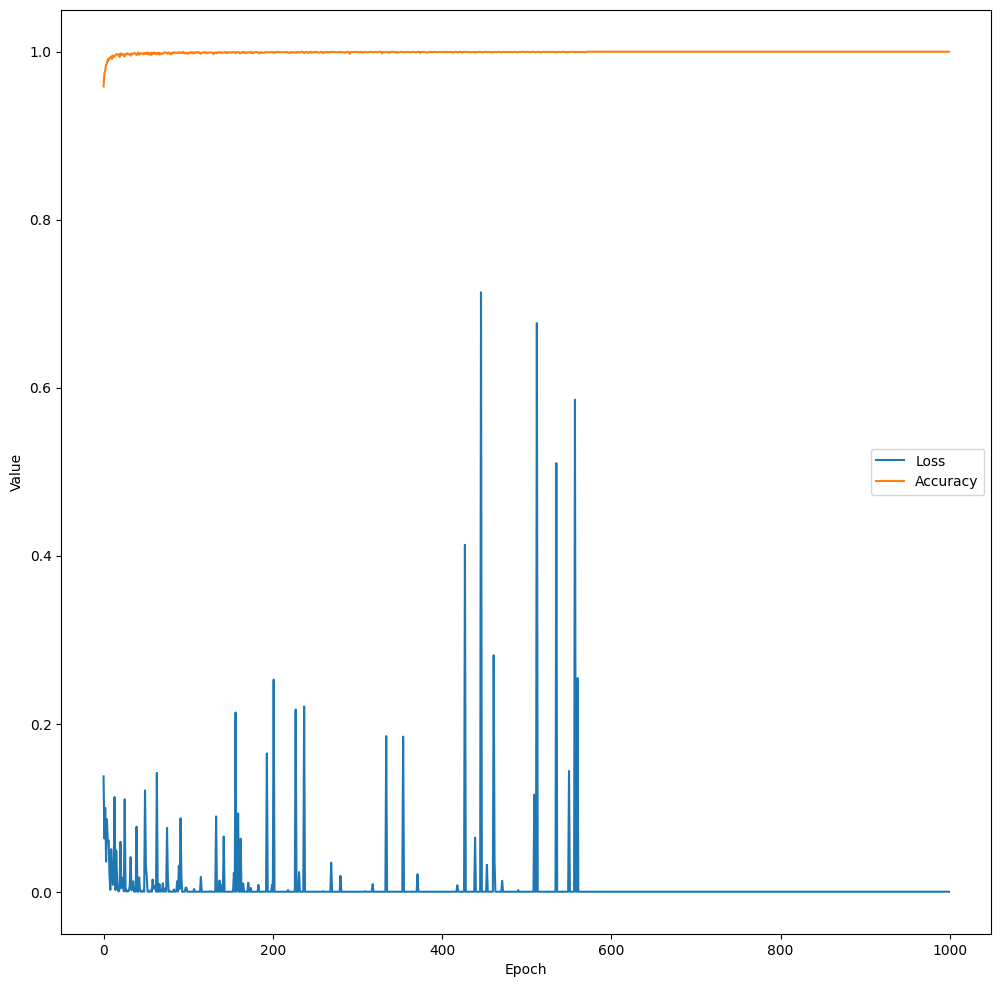

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
# Crear el dataset y el DataLoader
dataset = TensorDataset(tX_train_cnn, ty_train)
dataloader_nn2 = DataLoader(dataset, batch_size=100, shuffle=True)

# Crear el optimizador
optimizer_3 = optim.Adam(nn2.parameters(), lr=0.0025)

# Listas para almacenar el accuracy y el loss
accuracy_list = []
loss_list = []

# Entrenamiento
for epoch in range(1000):
    for batch_x, batch_y in dataloader_nn2:
        loss = train_step(batch_x, batch_y, nn2, optimizer_3)

    accuracy = evaluate(tX_train_cnn, ty_train, nn2)

    loss_list.append(loss)
    accuracy_list.append(accuracy)

    if epoch % 100 == 0:
        print("Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f}".format(epoch, loss, accuracy))

# Visualización del accuracy y el loss
plt.plot(loss_list, label='Loss')
plt.plot(accuracy_list, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

# 8. Comparativa de métricas y matrices de confusión entre todos los modelos entrenados de ML y DL. (1 punto)

El objetivo de esta sección es comparar los resultados obtenidos entre los distintos modelos (ML, NN, CNN).

En particular:
- Mostrar la matriz de confusión para cada modelo.
- Elegir y dibujar algunas métricas adicionales.
- Describir las conclusiones.

#### 8.1 - Mostrar la matriz de confusión para cada modelo.

##### 8.1.1 - ML Clasico

In [ ]:
#Matriz de confusion de la regresion lineal (ML Clasico).

from IPython.display import display, HTML

clasifiers = [model_linear_clasico, model_logistic_clasico, random_forest_clasico]

print(f"---------------------------------------------------------------------------")
for model in clasifiers:
    confusion = confusion_matrix(y_test, model.predict(X_test_n), labels=list(range(10)))
    df = pd.DataFrame(confusion, index = list(range(10)), columns = list(range(10)))
    print(f"Confusion matrix of the {model} and the accuracy of the model is {model.score(X_test_n, y_test)}")
    print(df.to_markdown())
    print(f"---------------------------------------------------------------------------")

---------------------------------------------------------------------------
Confusion matrix of the LinearSVC() and the accuracy of the model is 0.8602
|    |   0 |    1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |
|---:|----:|-----:|----:|----:|----:|----:|----:|----:|----:|----:|
|  0 | 927 |    0 |   5 |   5 |   3 |  17 |  14 |   4 |   3 |   2 |
|  1 |   3 | 1044 |  43 |   0 |   1 |   4 |   3 |   1 |  36 |   0 |
|  2 |  12 |   10 | 868 |  21 |  20 |   9 |  28 |  13 |  44 |   7 |
|  3 |   5 |    1 |  45 | 856 |   4 |  26 |   3 |  18 |  32 |  20 |
|  4 |   2 |    2 |   4 |   4 | 871 |   6 |  24 |   9 |  29 |  31 |
|  5 |  12 |   12 |  14 |  41 |  33 | 673 |  24 |  11 |  61 |  11 |
|  6 |  11 |    1 |  13 |   4 |  13 |  13 | 888 |   2 |   8 |   5 |
|  7 |   6 |   17 |  19 |  11 |  13 |   9 |   0 | 882 |  14 |  57 |
|  8 |  16 |   11 |  24 |  20 |  17 |  42 |  24 |  12 | 787 |  21 |
|  9 |   8 |   10 |   1 |   7 |  68 |  32 |   2 |  45 |  30 | 806 |
--------------------------------

#### 8.1.2 - HOG Features

In [ ]:
clasifiers = [model_linear_hog, model_logistic_hog, random_forest_hog]

print(f"---------------------------------------------------------------------------")
for model in clasifiers:
    confusion = confusion_matrix(y_test[::10], model.predict(X_test_hog), labels=list(range(10)))
    df = pd.DataFrame(confusion, index = list(range(10)), columns = list(range(10)))
    print(f"Confusion matrix of the {model} and the accuracy of the model is {model.score(X_test_hog, y_test[::10])}.")
    print(df.to_markdown())
    print(f"---------------------------------------------------------------------------")

---------------------------------------------------------------------------
Confusion matrix of the LinearSVC() and the accuracy of the model is 0.956.
|    |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |
|---:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
|  0 |  94 |   0 |   0 |   0 |   0 |   1 |   1 |   0 |   0 |   0 |
|  1 |   0 | 114 |   0 |   0 |   1 |   0 |   0 |   0 |   0 |   0 |
|  2 |   0 |   0 |  87 |   0 |   0 |   0 |   0 |   0 |   2 |   0 |
|  3 |   0 |   0 |   0 | 118 |   0 |   3 |   0 |   1 |   0 |   1 |
|  4 |   0 |   0 |   0 |   1 |  80 |   0 |   1 |   0 |   0 |   5 |
|  5 |   1 |   0 |   0 |   3 |   1 |  93 |   1 |   0 |   0 |   0 |
|  6 |   1 |   0 |   0 |   0 |   1 |   1 |  85 |   0 |   0 |   0 |
|  7 |   0 |   3 |   0 |   1 |   1 |   0 |   0 | 103 |   0 |   3 |
|  8 |   0 |   0 |   0 |   0 |   0 |   1 |   1 |   0 |  87 |   0 |
|  9 |   0 |   1 |   0 |   0 |   2 |   1 |   0 |   2 |   2 |  95 |
--------------------------------------------

#### 8.2 Elegir y dibujar algunas métricas adicionales.

Visualizacion de las metricas de la red neuronal "fully connected".

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Crear una lista para almacenar las predicciones y las etiquetas verdaderas
predictions = []
true_labels = []

# Poner el modelo en modo de evaluación
nn1.eval()

# Iterar sobre el dataloader y obtener las predicciones y las etiquetas verdaderas
for inputs, labels in dataloader_nn1:
    outputs = nn1.forward(inputs)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(predicted.numpy())
    true_labels.extend(labels.numpy())

# Convertir las listas en arreglos NumPy
y_pred = np.array(predictions)
y_true = np.array(true_labels)

# Calcular las métricas
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Imprimir los resultados
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9926853974434972
Recall: 0.9926855159900327
F1 Score: 0.9926840535720661


Visualizacion de las metricas de la red neuronal convolucional.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Crear una lista para almacenar las predicciones y las etiquetas verdaderas
predictions = []
true_labels = []

# Poner el modelo en modo de evaluación
nn1.eval()

# Iterar sobre el dataloader y obtener las predicciones y las etiquetas verdaderas
for inputs, labels in dataloader_nn2:
    outputs = nn2.forward(inputs)
    _, predicted = torch.max(outputs.data, 1)
    predictions.extend(predicted.numpy())
    true_labels.extend(labels.numpy())

# Convertir las listas en arreglos NumPy
y_pred = np.array(predictions)
y_true = np.array(true_labels)

# Calcular las métricas
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Imprimir los resultados
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


#### 8.3 - Describir las conclusiones.

Las métricas de evaluación y la matriz de confusión son herramientas fundamentales para analizar el rendimiento de las redes neuronales en tareas de clasificación. Las métricas, como la precisión, el recall, la F1-score y la exactitud, nos brindan información detallada sobre cómo la red está realizando las predicciones en comparación con los valores reales. Estas métricas nos permiten evaluar el desempeño general del modelo y comparar diferentes configuraciones o arquitecturas de la red.

Por otro lado, la matriz de confusión proporciona una visión más completa de las predicciones del modelo al mostrar la distribución de las clasificaciones correctas e incorrectas. La matriz muestra los valores reales en las filas y las predicciones en las columnas, lo que permite identificar los aciertos y los errores en cada clase. Esto es especialmente útil en problemas de clasificación multiclase, donde se pueden analizar los falsos positivos, falsos negativos y otros errores específicos de cada clase.

En conjunto, las métricas de evaluación y la matriz de confusión nos brindan una visión completa y detallada del rendimiento de una red neuronal en la tarea de clasificación. Estas herramientas son cruciales para comprender las fortalezas y debilidades del modelo, identificar posibles mejoras y tomar decisiones informadas sobre ajustes en la arquitectura de la red o en los hiperparámetros de entrenamiento. Al utilizar estas métricas y análisis, podemos optimizar nuestras redes neuronales para lograr un rendimiento óptimo en diversas aplicaciones de aprendizaje automático.

# 9. Comparativa de la robustez de los distintos modelos entrenados frente a la translación horizontal de los dígitos. (0,5 puntos)

El objetivo de esta sección es:
- Probar el rendimiento de los modelos entrenados sobre distintas transformaciones del set de testing (por ejemplo, sobre translaciones horizontales como se mostró en las sesiones de este módulo).
- Dibujar las gráficas correspondientes de acierto frente a la magnitud de la transformación (por ej. cantidad de píxeles desplazados).
- Describir las conclusiones.

In [ ]:
import numpy as np

In [ ]:
X_test.shape

(10000, 28, 28)

In [ ]:
tr_W = np.array(list(range(-50,50)))
X_test_Ws = [np.roll(X_test, i, axis=2) for i in tr_W]

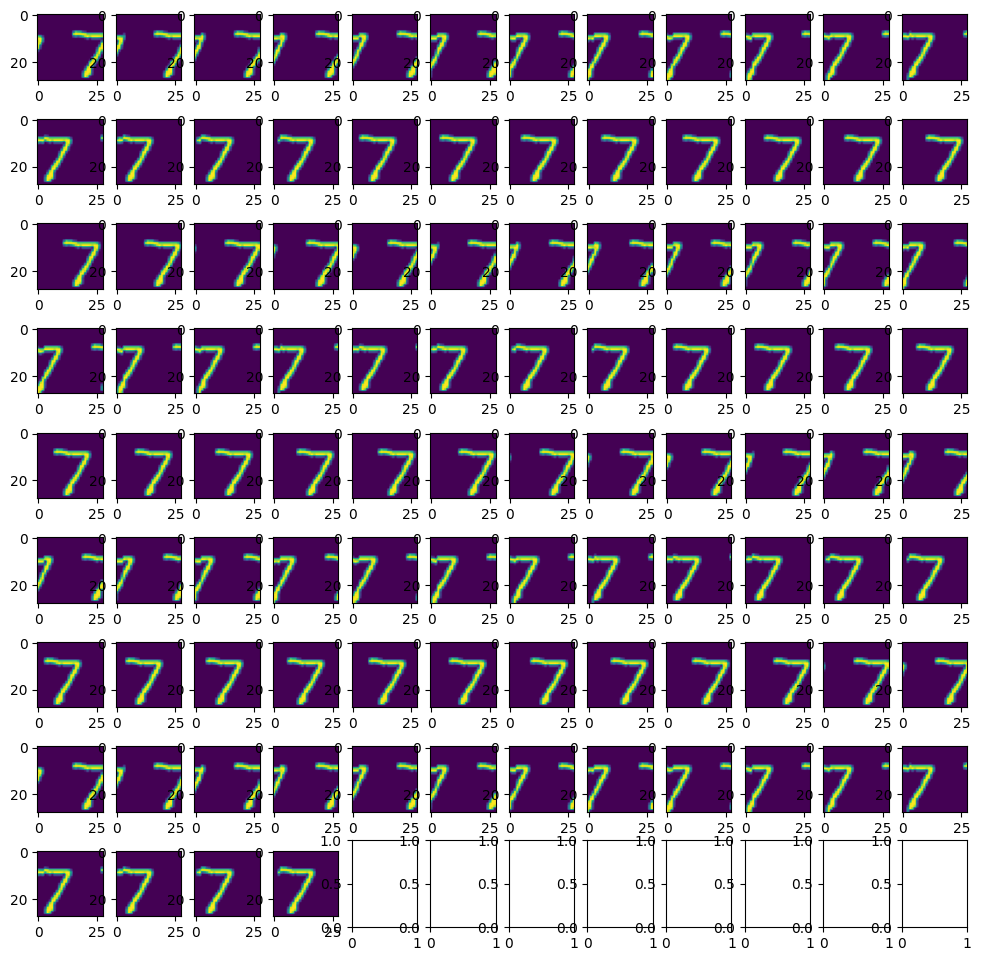

In [ ]:
from skimage import io
im = io.imshow_collection([np.roll(0.5 + xi[0], (2, 0, 1)) for xi in X_test_Ws])

In [ ]:
print(type(X_test_Ws))


<class 'list'>


In [ ]:
def pred_f(x, forw):
    with torch.no_grad():
        _, y_pred = torch.max(forw(x), dim=1)
    return y_pred

def score_f(x, y, forw):
    with torch.no_grad():
        y_pred = pred_f(x, forw)
        score = torch.sum(y_pred == y).item() / len(y)
    return score

nn1_scores = [score_f(torch.tensor(xi.reshape(xi.shape[0],-1), requires_grad=False, dtype=torch.float),
                      ty_test, nn1) for xi in X_test_Ws]

In [ ]:
cnn1_scores = [score_f(torch.tensor(xi, requires_grad=False, dtype=torch.float),
                      ty_test, nn2) for xi in X_test_Ws]

In [ ]:
all_scores = pd.DataFrame(data={
    'nn1': nn1_scores,
    'cnn1': cnn1_scores
}, index=tr_W)

<Axes: >

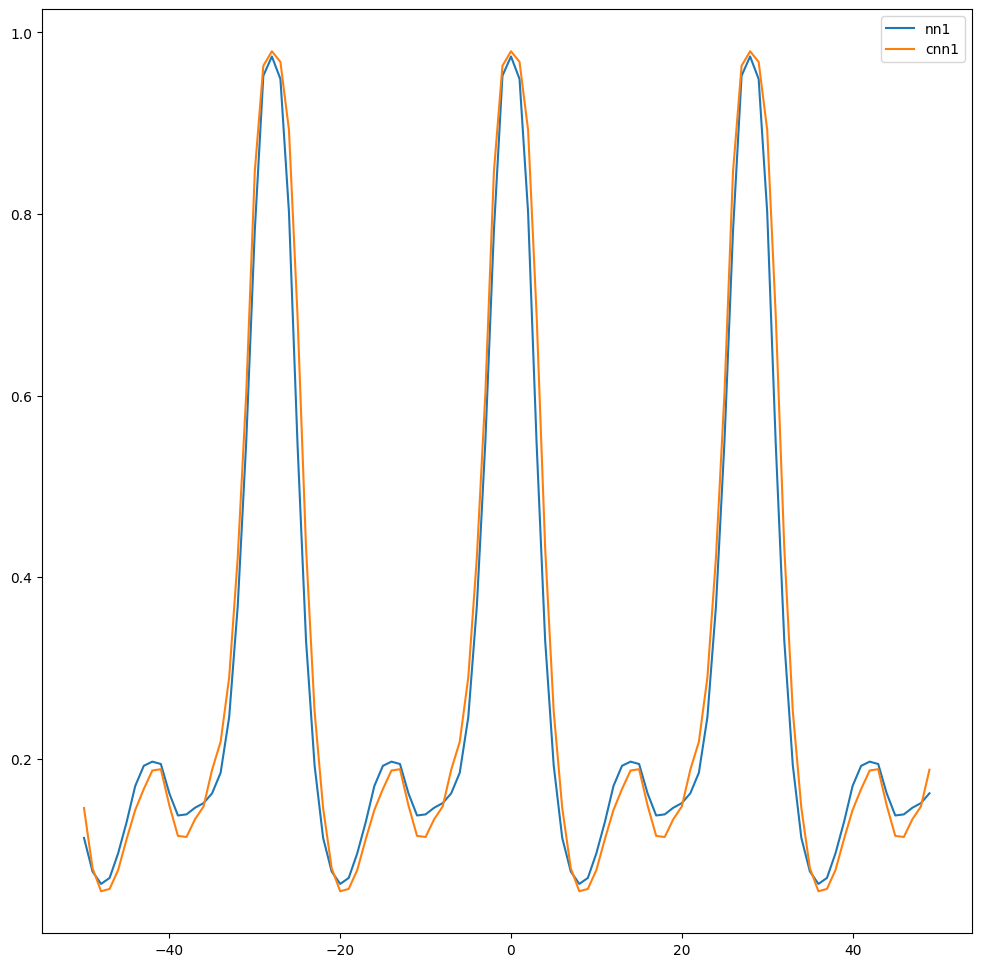

In [ ]:
all_scores.plot()

Es interesante que ambas coinciden en las predicciones obtenidas, pero las redesc onvolucionales deberian ser mas robustas ante la trsnalacion de imagenes, por lo que debe haber algun error.

# 10. Desarrollo de una función de preprocesado / reescalado para input al modelo, y exportación del modelo escogido. (0,5 puntos)


El objetiivo de esta sección es el de preparar el modelo para su despliegue en la Parte II de la práctica.

Para ello, habrá que:
- Seleccionar el mejor modelo entre los probados (típicamente, debería ser la CNN).
- Construir una función de preprocesado (o una pipeline de scikit-learn, o equivale) que transforme una imágen genérica en algo consumible por el modelo, replicando también las transformaciones hechas durante el entrenamiento.
- Exportar el modelo y la pipeline en un formato importable desde una aplicación python, como por ejemplo un fichero “.pt” (pytorch) con los pesos de la red neuronal, o una de la pipeline entera a un fichero “.pkl” (pickle).


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


# Clase personalizada para realizar las transformaciones de la CNN
class cnn_transform(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = torch.tensor(X / 255.0, requires_grad=False, dtype=torch.float32)
        X_transformed = torch.unsqueeze(X_transformed, 1)
        if y is not None:
            y_transformed = torch.tensor(y / 255.0, requires_grad=False, dtype=torch.long)
            return X_transformed, y_transformed
        else:
            return X_transformed

    def fit_transform(self, X, y=None):
        return self.transform(X, y)

# Crear el pipeline
pipeline = Pipeline([
    ('transform', cnn_transform()),  # Transformación personalizada
    ('model', nn2)  # Red neuronal
])

# Definir los parámetros de optimización
learning_rate = 0.001
batch_size = 64
epochs = 10

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pipeline['model'].parameters(), lr=learning_rate)

# Entrenar el modelo
for epoch in range(epochs):
    running_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs, labels = pipeline['transform'].transform(X_train[i:i+batch_size], y_train[i:i+batch_size])

        # Reiniciar los gradientes
        optimizer.zero_grad()

        # Forward + Backward + Optimizar
        outputs = pipeline['model'](inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calcular la pérdida promedio en cada época
    average_loss = running_loss / (len(X_train) // batch_size)
    print(f'Epoch {epoch+1}/{epochs} - Loss: {average_loss:.4f}')

# Evaluar el modelo
pipeline['model'].eval()
with torch.no_grad():
    inputs, labels = pipeline['transform'].transform(X_test, y_test)
    outputs = pipeline['model'](inputs)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == labels).sum().item() / len(labels)
    print(f'Accuracy on test set: {accuracy:.4f}')


Epoch 1/10 - Loss: 37.6604
Epoch 2/10 - Loss: 0.0477
Epoch 3/10 - Loss: 0.0146
Epoch 4/10 - Loss: 0.0042
Epoch 5/10 - Loss: 0.0010
Epoch 6/10 - Loss: 0.0000
Epoch 7/10 - Loss: 0.0000
Epoch 8/10 - Loss: 0.0000
Epoch 9/10 - Loss: 0.0000
Epoch 10/10 - Loss: 0.0000
Accuracy on test set: 0.9999


In [ ]:
import pickle


# Guardar el modelo en un archivo pickle
with open('modelo.pickle', 'wb') as file:
    pickle.dump(pipeline, file)

Comprobamos el guardado del archivo y lo cargamos para testear su correcto funcionamiento.

In [ ]:
# Cargar el modelo desde el archivo pickle
with open('modelo.pickle', 'rb') as file:
    pipeline = pickle.load(file)

Tambien podemos guardar y cargar un modelo con Pytorch de la siguiente manera con el archivo que queramos, pero en el caso de cargar el modelo entrenado en otro notebook hay que definir la clase de la red neuronal para que no haya problemas ya que solo guarda los pesos y algunos resultados.

In [ ]:
# Guardar el modelo
torch.save(pipeline, 'pipeline.pth')

# Cargar el modelo
model = torch.load('pipeline.pth')

In [ ]:
print(model)

Pipeline(steps=[('transform', cnn_transform()),
                ('model',
                 Net(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
))])
